# Development of polymer building, including monomer and bonding spec

In [3]:
# Supressing annoying warnings (!must be done first!)
import warnings
warnings.catch_warnings(record=True)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

import logging
logging.basicConfig(
    level=logging.INFO,
    format =LOG_FORMATTER._fmt,
    datefmt=LOG_FORMATTER.datefmt,
    force=True
)
LOGGER = logging.getLogger(__name__)

from rdkit import Chem
from rdkit.Chem import RWMol, BondType

from polymerist import rdutils
from polymerist.rdutils import rdkdraw
from polymerist.rdutils.rdtypes import RDAtom, RDBond, RDMol
from polymerist.rdutils.labeling import atomwise, molwise
from polymerist.rdutils.labeling.molwise import assign_ordered_atom_map_nums
from polymerist.rdutils.amalgamation import bonding, portlib

from polymerist.genutils.iteration import iter_len
from polymerist.genutils.decorators.functional import optional_in_place

# Interconversion from bare SMILES to complete monomer fragments

In [63]:
PVC_SMARTS = "[1#0:7]-[#6D4+0:1](-[#1D1+0:2])(-[#1D1+0:3])-[#6D4+0:4](-[#17D1+0:5])(-[#1D1+0:6])-[2#0:14]"
GLUC_SMILES = 'N[C@H]1C(O)OC(CO)[C@@H](O)[C@@H]1O'
METHYL = Chem.MolFromSmarts('[#6D4+0](-[3#0])(-[2#0])(-[4#0])(-[1#0])')
STYRENE_SMILES = 'c1ccc[13cH]c1C-C'

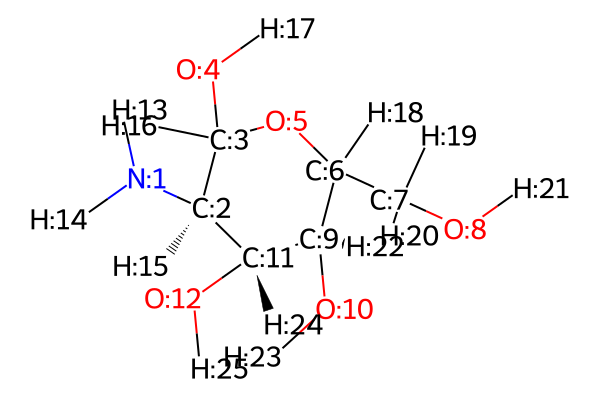

[N:1](-[C@@:2]1(-[H:15])-[C:3](-[O:4]-[H:17])(-[H:16])-[O:5]-[C:6](-[C:7](-[O:8]-[H:21])(-[H:19])-[H:20])(-[H:18])-[C@:9](-[O:10]-[H:23])(-[H:22])-[C@@:11]-1(-[O:12]-[H:25])-[H:24])(-[H:13])-[H:14]


In [64]:
from polymerist.monomers.substruct import specification
from polymerist.rdutils.labeling import molwise
from polymerist.rdutils import rdkdraw
rdkdraw.set_rdkdraw_size(400, 3/2)

smiles = GLUC_SMILES
new_smiles = specification.expanded_SMILES(smiles)
FULL_SMILES_MOL = Chem.MolFromSmiles(new_smiles, sanitize=False)
display(FULL_SMILES_MOL)
print(new_smiles)

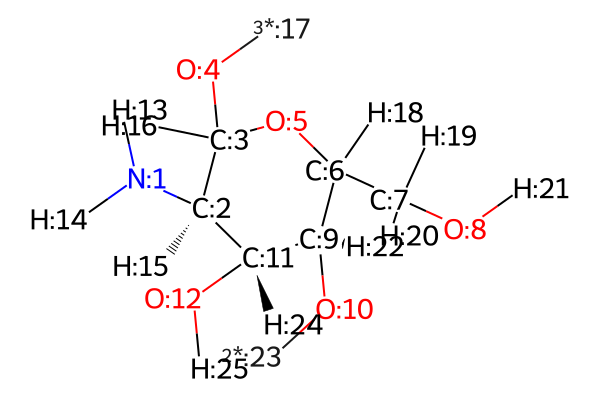

In [65]:
isotope_map = {
    17 : 3,
    23 : 2
}

map_nums = isotope_map.keys()
for (atom_id, map_num) in zip(molwise.atom_ids_by_map_nums(FULL_SMILES_MOL, *map_nums), map_nums):
    linker_atom = FULL_SMILES_MOL.GetAtomWithIdx(atom_id)
    linker_atom.SetIsotope(isotope_map[map_num])
    linker_atom.SetAtomicNum(0)

display(FULL_SMILES_MOL)

Cleaned 22 SMARTS atom query aberrations by RDKit


[#7D3+0:1](-[#6@@&D4&+0:2]1(-[#1D1+0:15])-[#6D4+0:3](-[#8D2+0:4]-[3#0:17])(-[#1D1+0:16])-[#8D2+0:5]-[#6D4+0:6](-[#6D4+0:7](-[#8D2+0:8]-[#1D1+0:21])(-[#1D1+0:19])-[#1D1+0:20])(-[#1D1+0:18])-[#6@&D4&+0:9](-[#8D2+0:10]-[2#0:23])(-[#1D1+0:22])-[#6@@&D4&+0:11]-1(-[#8D2+0:12]-[#1D1+0:25])-[#1D1+0:24])(-[#1D1+0:13])-[#1D1+0:14]


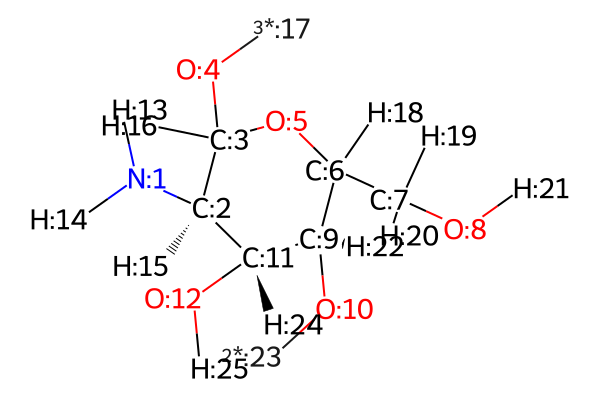

In [67]:
base_smarts = Chem.MolToSmarts(FULL_SMILES_MOL)
spec_smarts = specification.compliant_mol_SMARTS(base_smarts)
monomer = Chem.MolFromSmarts(spec_smarts)
print(spec_smarts)
display(monomer)

Cleaned 18 SMARTS atom query aberrations by RDKit


'[#6D3+0:1]1(-[#1D1+0:9])=[#6D3+0:2](-[#1D1+0:10])-[#6D3+0:3](-[#1D1+0:11])=[13#6D3+0:4](-[#1D1+0:12])-[13#6D3+0:5](-[#1D1+0:13])=[#6D3+0:6]-1-[#6D4+0:7](-[#6D4+0:8](-[#1D1+0:16])(-[#0:17])-[#1D1+0:18])(-[#1D1+0:14])-[3#0:15]'

# Port-binding rules

## Test structures

In [ ]:
# some "normal" molecules for testing
H  = Chem.MolFromSmarts('[#1]-[1#0]')
OH = Chem.MolFromSmarts('[#1]-[O]-[2#0]')
METHYL = Chem.MolFromSmarts('[#6](-[2#0])(-[2#0])(-[3#0])(-[1#0])')
CARBONYL = Chem.MolFromSmarts('[#6]-[#6](=[#8])-[1#0]')
WITTIG = Chem.MolFromSmarts('[#6](=[1#0])(-[2#0])(-[#1])')
WITTIG_DUAL = Chem.MolFromSmarts('[#6](=[1#0])(-[#7](-[#1])(-[#1]))(-[#1])')

TEST_MOLS_NORMAL = (
    H,
    OH,
    METHYL,
    WITTIG,
    WITTIG_DUAL,
    CARBONYL
)

# Pathological examples for debug
DOUBLE_MID = Chem.MolFromSmarts('[#6](-[1#0])(-[#1])=[#0]-[#6](-[#1])(-[#1])(-[2#0])')
NEUTRONIUM = Chem.MolFromSmarts('[#0]-[#0]')
GHOST_WATER = Chem.MolFromSmarts('[#1]-[#0]-[#1]')

TEST_MOLS_PATHO = (
    DOUBLE_MID,
    NEUTRONIUM,
    GHOST_WATER
)

# COMBINE FOR UNIVERSAL TESTING
TEST_MOLS = (
    *TEST_MOLS_NORMAL,
    *TEST_MOLS_PATHO
)

In [ ]:
rdkdraw.disable_substruct_highlights()

for mol in TEST_MOLS:
    assign_ordered_atom_map_nums(mol, in_place=True)
    print(portlib.get_num_ports(mol))
    display(mol)

## Testing bond dissolution and splicing 

In [ ]:
a1 = 2 - 1 # indices of atoms to target
a2 = 3 - 1 # indices of atoms to target
flavor_pair = (1, 3) # pair of port flavors to interface together

display(CARBONYL)
frags = bonding.dissolve_bond(Chem.RWMol(CARBONYL), a1, a2, new_port_flavor=3)
MET, OXY = Chem.GetMolFrags(frags, asMols=True, sanitizeFrags=True)

display(frags)
display(MET)
display(OXY)

portlib.Port.bondable_flavors.insert(flavor_pair)
bondable_pair = portlib.get_first_bondable_port_pair(frags, a1, a2, flavor_pair=flavor_pair)
prod1 = bonding.splice_atoms(frags, 1, 2, flavor_pair=(1,3), in_place=False)
display(prod1)

In [ ]:
TEST = bonding.combined_rdmol(METHYL, OXY)
display(TEST)

order2 = portlib.max_bondable_order_between_atoms(TEST, 0, 5, target_flavor=3)
prod2 = bonding.splice_atoms(TEST, 0, 5, flavor_pair=(1,3))

print(order2)
display(prod2)

## Testing port saturation

### Testing single bonds

In [ ]:
H_GENERIC = Chem.MolFromSmarts('[#1]-[#0]')
OH_GENERIC = Chem.MolFromSmarts('[#1]-[O]-[4#0]')
METHYL_GENERIC = Chem.MolFromSmarts('[#6](-[#0])(-[#0])(-[#0])(-[#0])')

display(H_GENERIC)
display(OH_GENERIC)
display(METHYL_GENERIC)

In [ ]:
bonding.saturate_ports(METHYL_GENERIC, H_GENERIC)

In [ ]:
portlib.Port.bondable_flavors.insert((0,4))
bonding.saturate_ports(METHYL_GENERIC, OH_GENERIC)

In [ ]:
bonding.saturate_ports(METHYL_GENERIC, H_GENERIC)

### Testing double bonds

In [ ]:
CARBENE = Chem.MolFromSmarts('[2#0:1]=[#6:2]=[#0:3]')
DIOX    = Chem.MolFromSmarts('[#0:1]=[#8:2]')

display(CARBENE)
display(DIOX)

In [ ]:
bonding.saturate_ports(CARBENE, cap=DIOX, flavor_to_saturate=2)

### Testing selectivity between mixed single and double bonds

In [ ]:
C3 = Chem.MolFromSmarts('[#6:1](=[#0:2])(-[#0:3])(-[#0:4])')
C3

In [ ]:
bonding.saturate_ports(C3, cap=DIOX)

### Testing the null case (no bonds formable, but with flavors matching)

# Testing different measures of atom degree

In [60]:
import pandas as pd
from polymerist.genutils.iteration import iter_len

records = []
for atom in mol.GetAtoms():
    record = {
        'symbol' : atom.GetSymbol(),
        'map num' : atom.GetAtomMapNum(),
        'num bonds' : iter_len(atom.GetBonds()),
        'impl_valence' : atom.GetImplicitValence(),
        'expl_valence' : atom.GetExplicitValence(),
        'total_valence' : atom.GetTotalValence(),
    }
    records.append(record)
df = pd.DataFrame.from_records(records)
df

NameError: name 'mol' is not defined

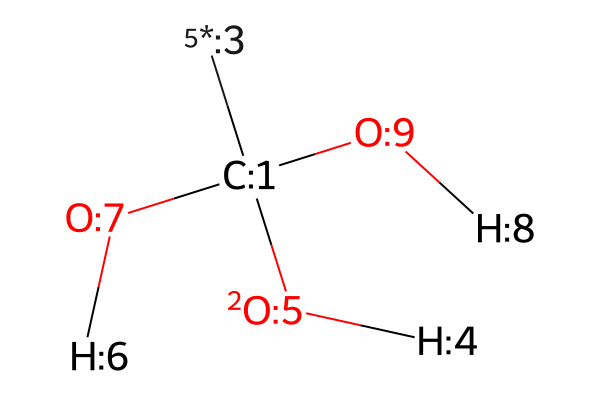

[#6D4+0:1](-[5#02*:3])(-[2#8D2+0:5]-[#1D1+0:4])(-[#8D2+0:7]-[#1D1+0:6])-[#8D2+0:9]-[#1D1+0:8]
[#6&D4&+0:1](-[#0&5*&2*:3])(-[#8&2*&D2&+0:5]-[#1&D1&+0:4])(-[#8&D2&+0:7]-[#1&D1&+0:6])-[#8&D2&+0:9]-[#1&D1&+0:8]


In [61]:
s = '[#6D4+0:1](-[5#02*:3])(-[2#8D2+0:5]-[#1D1+0:4])(-[#8D2+0:7]-[#1D1+0:6])-[#8D2+0:9]-[#1D1+0:8]'
mol3 = Chem.MolFromSmarts(s)
display(mol3)
print(s)
print(Chem.MolToSmarts(mol3))